<a href="https://colab.research.google.com/github/VitalyGladyshev/gb_dl_cv/blob/main/vs_hw_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 8

Реализовать синтезирование лиц из LFW с помощью DCGAN
Библиотеки: [Python, Tensorflow]

In [19]:
%tensorflow_version 2.x

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [45]:
train_ds, ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split='train'
)

In [46]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [47]:
len(train_ds)

13233

In [48]:
train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [49]:
elem = train_ds.take(1)

for label, image in elem:
    print(image.shape, label)

(250, 250, 3) tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


In [50]:
ds = train_ds.take(32)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

## Создание пайплайна данных

In [51]:
INP_SIZE = 128
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare(label, img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5 # / 255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
# train_ds = train_ds.take(12800)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [53]:
train_ds

<BatchDataset shapes: (16, 128, 128, 3), types: tf.float32>

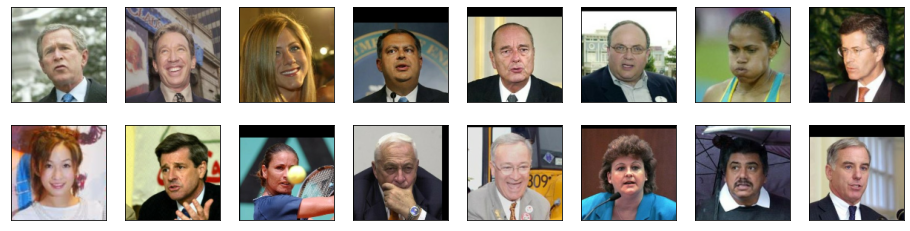

In [54]:
fig = plt.figure(figsize=(16, 4))
j = 0
for batch in tfds.as_numpy(train_ds.take(1)):
    for image in batch:
        ax = fig.add_subplot(2, 8, j+1)
        ax.imshow((image+1)/2.)
        plt.xticks([]), plt.yticks([])
        j += 1
plt.show()

## Deep Convolutional GAN (DCGAN)

In [60]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    # tf.keras.layers.UpSampling2D((2, 2)),    
    # tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=0.8),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    # tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [61]:
INPUT_DIM = 100
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [62]:
def plot_faces(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(INP_SIZE, INP_SIZE, 3)+1)/2.)
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.9434; G Loss: 0.6277


[Step 200] D Loss: 0.1618; G Loss: 0.0028


[Step 400] D Loss: 0.0002; G Loss: 0.0045


[Step 600] D Loss: 0.0000; G Loss: 37.4472


[Step 800] D Loss: 0.7914; G Loss: 16.7471


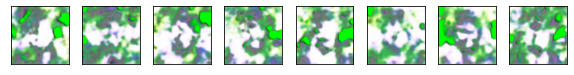

[Step 1000] D Loss: 0.9718; G Loss: 23.2507


[Step 1200] D Loss: 2.0719; G Loss: 3.9428


[Step 1400] D Loss: 1.5246; G Loss: 4.1827


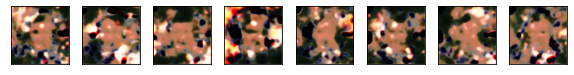

[Step 1600] D Loss: 0.0001; G Loss: 11.5720


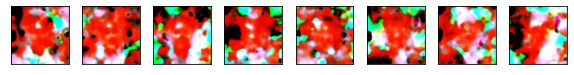

[Step 1800] D Loss: 0.6174; G Loss: 1.9394


[Step 2000] D Loss: 0.6054; G Loss: 2.9366


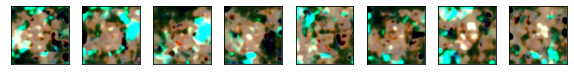

[Step 2200] D Loss: 0.3723; G Loss: 2.5341


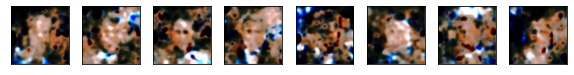

[Step 2400] D Loss: 1.5306; G Loss: 3.8297


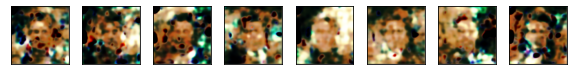

[Step 2600] D Loss: 0.5793; G Loss: 0.9400


[Step 2800] D Loss: 0.2380; G Loss: 7.2029


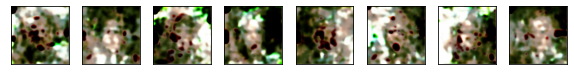

[Step 3000] D Loss: 0.0323; G Loss: 0.7626


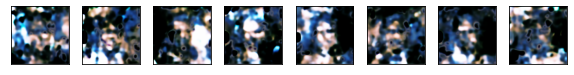

[Step 3200] D Loss: 0.2785; G Loss: 4.9174


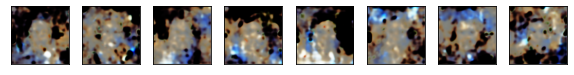

[Step 3400] D Loss: 1.0086; G Loss: 2.4131


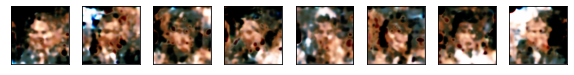

[Step 3600] D Loss: 0.6168; G Loss: 0.5766


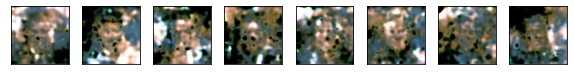

[Step 3800] D Loss: 0.7400; G Loss: 1.3186


[Step 4000] D Loss: 1.5340; G Loss: 4.5044


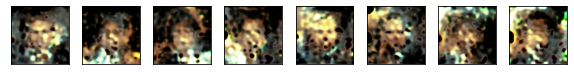

[Step 4200] D Loss: 0.9631; G Loss: 2.1172


[Step 4400] D Loss: 1.0492; G Loss: 1.8973


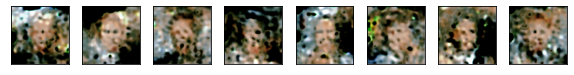

[Step 4600] D Loss: 0.2498; G Loss: 1.8250


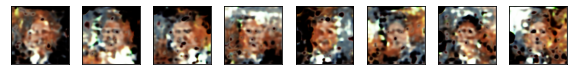

[Step 4800] D Loss: 0.4007; G Loss: 3.5708


[Step 5000] D Loss: 0.4425; G Loss: 5.3204


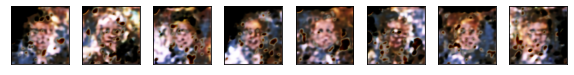

[Step 5200] D Loss: 0.0355; G Loss: 0.9170


[Step 5400] D Loss: 0.8793; G Loss: 4.2085


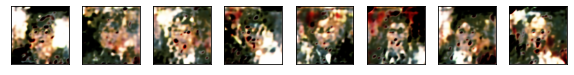

[Step 5600] D Loss: 1.2549; G Loss: 0.5171


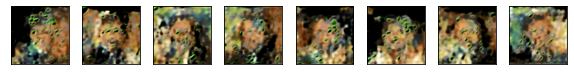

[Step 5800] D Loss: 0.1823; G Loss: 4.8854


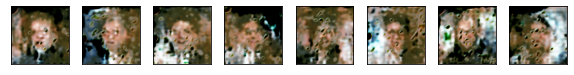

[Step 6000] D Loss: 1.2350; G Loss: 2.3769


[Step 6200] D Loss: 0.5867; G Loss: 5.8294


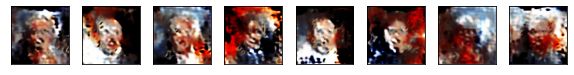

[Step 6400] D Loss: 0.7648; G Loss: 3.5140


[Step 6600] D Loss: 0.9942; G Loss: 0.7190


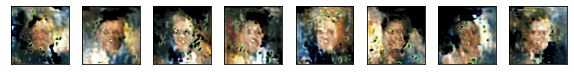

[Step 6800] D Loss: 0.1426; G Loss: 2.3656


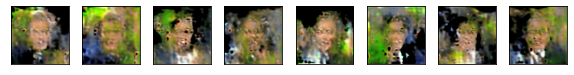

[Step 7000] D Loss: 0.6511; G Loss: 1.0774


[Step 7200] D Loss: 1.1268; G Loss: 2.0309


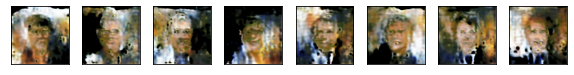

[Step 7400] D Loss: 0.1965; G Loss: 2.0560


[Step 7600] D Loss: 0.0192; G Loss: 8.8055


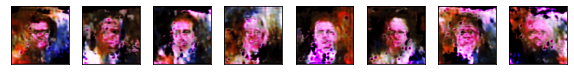

[Step 7800] D Loss: 0.9249; G Loss: 3.1706


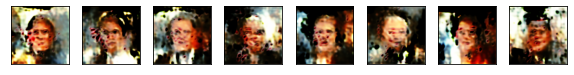

[Step 8000] D Loss: 0.1603; G Loss: 5.0407


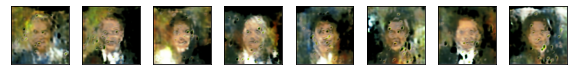

[Step 8200] D Loss: 0.7275; G Loss: 1.2017


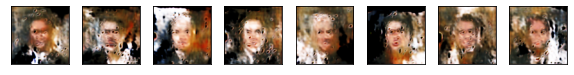

In [63]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    # print(syntetic_images.shape, true_images.shape)
    # break
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %3d] D Loss: %.6f; G Loss: %.6f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)

## Тестирование свёрточного генератора

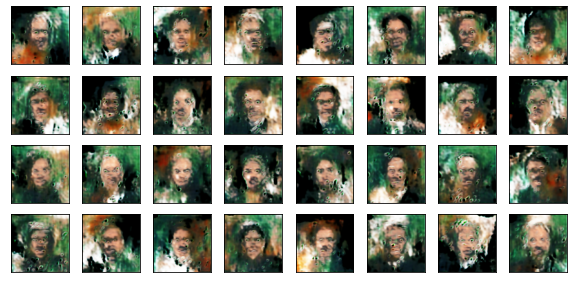

In [64]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

## Интерполяция в латентном пространстве

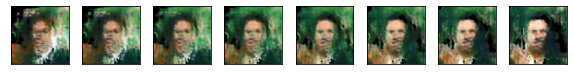

In [65]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

## Коментарии

В импрессионисты сеть уже годится :)

Нужно больше эпох и продолжить эксперименты с архитектурой, но это затратно по времени.